# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
! pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rwxr-xr-x 1 root root 1.2K Feb  3 20:03 README.md


## Запуск spark

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
! spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_242
Branch 
Compiled by user  on 2019-08-27T21:31:02Z
Revision 
Url 
Type --help for more information.


In [4]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [5]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [6]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [7]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [8]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [9]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [11]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [12]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [13]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [14]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=122701, mean_rating=5.0, ratings_count=1, movieId=122701, title='Love, Cheat & Steal (1993)', genres='Thriller'),
 Row(movie_id=174771, mean_rating=5.0, ratings_count=1, movieId=174771, title='Kino-pravda no. 14 (1923)', genres='(no genres listed)'),
 Row(movie_id=180585, mean_rating=5.0, ratings_count=1, movieId=180585, title='The Man Who Came to Dinner (2000)', genres='(no genres listed)'),
 Row(movie_id=128137, mean_rating=5.0, ratings_count=1, movieId=128137, title="You're Jinxed, Friend, You've Met Sacramento (1972)", genres='(no genres listed)'),
 Row(movie_id=184643, mean_rating=5.0, ratings_count=1, movieId=184643, title='Relentless (2018)', genres='Thriller'),
 Row(movie_id=143567, mean_rating=5.0, ratings_count=1, movieId=143567, title='Mining for Ruby (2014)', genres='(no genres listed)'),
 Row(movie_id=182461, mean_rating=5.0, ratings_count=1, movieId=182461, title='No Ordinary Hero: The SuperDeafy Movie', genres='(no genres listed)'),
 Row(movie_id=193795, me

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [15]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [16]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,356,81491,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,81482,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,79672,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,74127,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,72674,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,68717,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,64144,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,60411,527,Schindler's List (1993),Drama|War
8,110,59184,110,Braveheart (1995),Action|Drama|War
9,2959,58773,2959,Fight Club (1999),Action|Crime|Drama|Thriller


---
## SQL

In [17]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [18]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [19]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#131]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#134L, title#131]
+- Sort [count(1)#134L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#134L, first(title#31, false) AS title#131]
      +- Filter title#31 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#30 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#30,title#31,genres#32] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [20]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [21]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter((F.col('year').isNotNull()) & (F.col('year') < 2025)) \
    .groupby('year') \
    .count() \
    .sort(F.col('year')) \
    .toPandas()

In [22]:
relase_count_by_year.head()

,year,count
0,1874,1
1,1878,1
2,1880,1
3,1883,1
4,1887,1


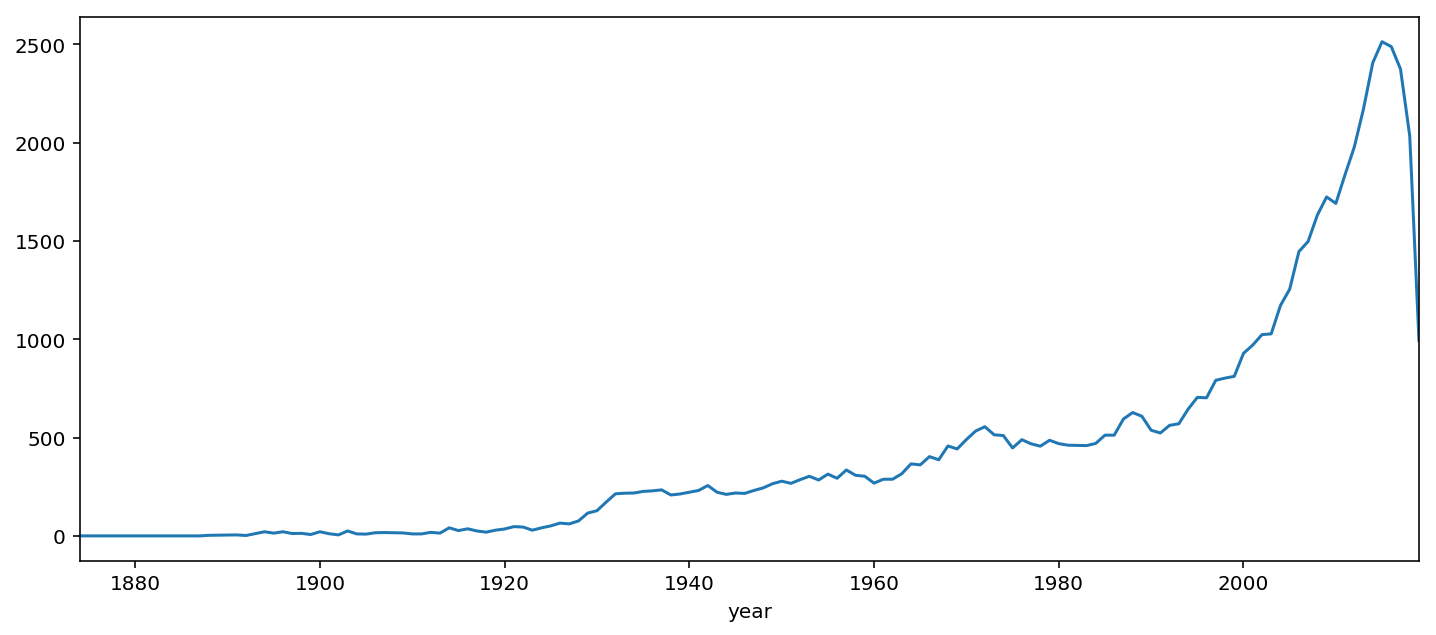

In [23]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [24]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

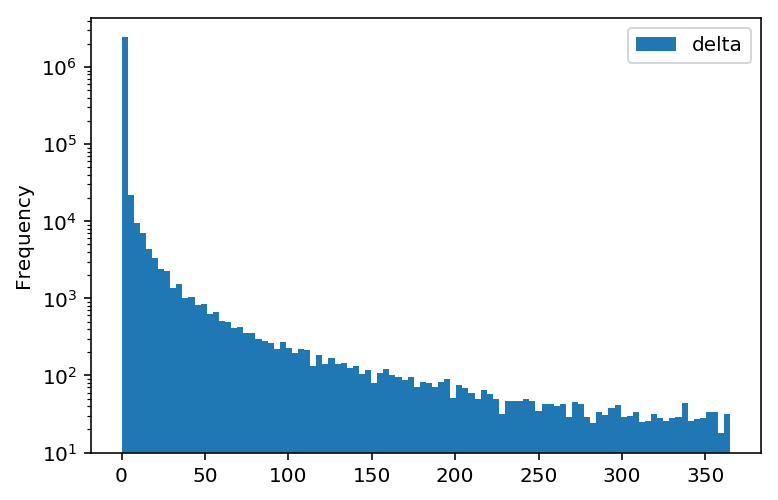

In [25]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

выберем произвольных 10к пользователей

In [26]:
n_users = 10000
selected_users = ratings_df \
    .select('user_id') \
    .distinct() \
    .sample(False, 0.01) \
    .limit(n_users)
# from: https://stackoverflow.com/a/32837900

In [27]:
ratings_df = ratings_df \
    .join(selected_users, 'user_id')

In [28]:
ratings_df = ratings_df.persist()

In [29]:
movies_df = movies_df.withColumnRenamed("movieId", "movie_id")

In [30]:
def get_similar_films(ratings_df, movie_ids, N=10, exclude_self=True):
    movie_reviewers = ratings_df \
            .filter(F.col('movie_id').isin(movie_ids)) \
            .select('user_id', 'movie_id') \
            .withColumnRenamed('user_id', 'selected_user_id') \
            .withColumnRenamed('movie_id', 'selected_movie_id')

    movie_reviewers_count = movie_reviewers \
        .groupby('selected_movie_id') \
        .count() \
        .withColumnRenamed('count', 'selected_viewers_number')

    intersections = ratings_df \
            .join(movie_reviewers, (ratings_df['user_id'] == movie_reviewers['selected_user_id'])) \
            .groupby('movie_id', 'selected_movie_id') \
            .count() \
            .withColumnRenamed('count', 'intersection')

    movie_count = ratings_df \
            .groupby('movie_id') \
            .count() \
            .withColumnRenamed('count', 'viewers_number')
    
    result = movie_count \
      .join(intersections, 'movie_id') \
      .join(movie_reviewers_count, 'selected_movie_id')

    result = result \
                .withColumn('sim', result['intersection'] / (result['selected_viewers_number'] + result['viewers_number'] - result['intersection'])) \
                .sort(F.col('selected_movie_id').asc(), F.col('sim').desc()) \
                .select('selected_movie_id', 'movie_id', 'sim')
    
    if exclude_self:
        result = result.filter(F.col('movie_id') != F.col('selected_movie_id'))
    
    return result

In [31]:
get_similar_films(ratings_df, [356], exclude_self=False) \
    .join(movies_df, "movie_id") \
    .sort(F.col('selected_movie_id').desc(), F.col('sim').desc()) \
    .limit(10).toPandas()

,movie_id,selected_movie_id,sim,title,genres
0,356,356,1.000000,Forrest Gump (1994),Comedy|Drama|Romance|War
1,480,356,0.544586,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
2,296,356,0.525214,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,318,356,0.506196,"Shawshank Redemption, The (1994)",Crime|Drama
4,593,356,0.501449,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
5,589,356,0.471519,Terminator 2: Judgment Day (1991),Action|Sci-Fi
6,110,356,0.467437,Braveheart (1995),Action|Drama|War
7,457,356,0.443219,"Fugitive, The (1993)",Thriller
8,377,356,0.422325,Speed (1994),Action|Romance|Thriller
9,2571,356,0.421933,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

In [32]:
import abc

In [33]:
class Recommender(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def recommend(self, user_id): raise NotImplementedError
        
    def prepare_result(self, ordered_films):
        return ordered_films \
                    .limit(self.N) \
                    .withColumn("rank", F.monotonically_increasing_id() + F.lit(1)) \
                    .select('movie_id', 'rank')
    
    def get_viewed_films(self, user_id):
        # выберем все фильмы, которые уже смотрел пользователь, чтобы не рекоммендовать
        films_viewed = self.ratings_df \
                                .filter(F.col('user_id') == user_id) \
                                .select('movie_id') \
                                .distinct() \
                                .agg(F.collect_list('movie_id').alias('movies')) \
                                .collect()[0]["movies"]
        return films_viewed

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [60]:
class Popular(Recommender):
    def __init__(self, ratings_df, exclude_viewed=True, N=10):
        self.ratings_df = ratings_df
        self.N = N
        self.exclude_viewed = exclude_viewed
        self.pop = ratings_df \
                    .groupby('movie_id') \
                    .count() \
                    .sort(F.col('count').desc()) \
                    .persist()
    
    def recommend(self, user_id):
        films_viewed = self.get_viewed_films(user_id) if self.exclude_viewed else [] 
        films = self.pop \
                        .filter(~F.col('movie_id').isin(*films_viewed))
        
        return self.prepare_result(films)

In [61]:
Popular(ratings_df, N=4, exclude_viewed=False, ).recommend(user_id=153095).toPandas()

,movie_id,rank
0,356,1
1,296,2
2,318,3
3,593,4


In [62]:
Popular(ratings_df, N=4, exclude_viewed=True).recommend(user_id=153095).toPandas()

,movie_id,rank
0,2571,1
1,260,2
2,527,3
3,1,4


Всё ок, не учитываются фильмы, которые пользователь уже смотрел

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

***
1. Мера близости — косинусная  
![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a8c50526e2cc7aa837477be87eff1ea703f9dec)  
Так как для простоты мы опустили информацию о самих рейтингах, оставив только посмотрел ли пользователь фильм или нет, то формула эквивалентна отношению числа фильмов, которые посмотрели оба пользователя, к произведению корней количества просмотренных фильмов

2. В числителе просто пересечение множества пользователей, которые посмотрели фильм, к множеству похожих пользователей. В знаменателе объединение этих двух множеств

In [39]:
import numpy as np

In [40]:
def get_similar_users(ratings_df, user_id):
    films_viewed = ratings_df \
            .filter(F.col('user_id') == user_id) \
            .select(F.col("movie_id"))
    films_viewed_count = films_viewed.count()
    
    intersection = ratings_df \
                        .join(films_viewed, on="movie_id") \
                        .groupby('user_id') \
                        .count() \
                        .withColumnRenamed('count', 'intersection') \
                        .filter(F.col('user_id') != user_id)
    
    total_viewed = ratings_df \
            .groupby('user_id') \
            .count() \
            .withColumnRenamed('count', 'total_viewed') \
            .filter(F.col('user_id') != user_id)
    
    
    result = intersection \
                .join(total_viewed, on="user_id")
    
    sim = result \
            .withColumn('sim', result['intersection'] / (np.sqrt(films_viewed_count) * F.sqrt(result['total_viewed']))) \
            .select('user_id', 'sim')
    
    return sim

In [63]:
get_similar_users(ratings_df, 153095).sort(F.col('sim').desc()).limit(2).toPandas()

,user_id,sim
0,3764,0.858116
1,53663,0.746004


In [65]:
class UCF(Recommender):
    def __init__(self, rating_df, alpha=0.2, exclude_viewed=True, N=10):
        self.ratings_df = ratings_df
        self.alpha = alpha
        self.exclude_viewed = exclude_viewed
        self.N = N
        
    def recommend(self, user_id):
        similar = get_similar_users(self.ratings_df, user_id) \
                            .filter(F.col('sim') > self.alpha) \
                            .select('user_id')
            
        similar_count = similar.count()
        
        intersection = self.ratings_df \
                        .filter(F.col('user_id') != user_id) \
                        .join(similar, on="user_id") \
                        .groupby('movie_id') \
                        .count() \
                        .withColumnRenamed('count', 'intersection')
        
        
        total_viewed = self.ratings_df \
                        .filter(F.col('user_id') != user_id) \
                        .groupby('movie_id') \
                        .count() \
                        .withColumnRenamed('count', 'total_users')
    
    
        result = intersection \
                    .join(total_viewed, on="movie_id")

        films = result \
                .withColumn('sim', result['intersection'] / (similar_count + result["total_users"] - result["intersection"])) \
                .sort(F.col('sim').desc())
        
        films_viewed = self.get_viewed_films(user_id) if self.exclude_viewed else [] 
        
        films = films \
                    .filter(~F.col('movie_id').isin(*films_viewed))
        
        return self.prepare_result(films)

In [66]:
UCF(ratings_df).recommend(user_id=153095).limit(4).toPandas()

,movie_id,rank
0,592,1
1,454,2
2,165,3
3,316,4


### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [71]:
class Item_kNN(Recommender):
    def __init__(self, ratings_df, exclude_viewed=True, N=10):
        self.ratings_df = ratings_df
        self.N = N
        self.exclude_viewed = exclude_viewed
    
    def recommend(self, user_id):
        films_viewed = self.get_viewed_films(user_id)
        
        rating = get_similar_films(self.ratings_df, films_viewed)
        
        films = rating \
                    .groupby("movie_id") \
                    .agg(F.sum(rating.sim).alias('total_sim')) \
                    .sort(F.col('total_sim').desc())
        
        if not self.exclude_viewed:
            films_viewed = []        
        
        films = films \
                    .filter(~F.col('movie_id').isin(*films_viewed))
        
        return self.prepare_result(films)

In [72]:
Item_kNN(ratings_df, exclude_viewed=False).recommend(153095).limit(5).toPandas()

,movie_id,rank
0,592,1
1,457,2
2,380,3
3,377,4
4,165,5


In [73]:
Item_kNN(ratings_df, exclude_viewed=True).recommend(153095).limit(5).toPandas()

,movie_id,rank
0,592,1
1,377,2
2,165,3
3,153,4
4,316,5


## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [74]:
def train_val_test_split(df, train_size=0.8, valid_size=0.1):
    # https://stackoverflow.com/a/51773836
    user_window = Window.orderBy('timestamp').partitionBy('user_id')
    
    df_with_ranks = df \
      .withColumn('rank', F.percent_rank().over(user_window))

    train = df_with_ranks \
      .filter(df_with_ranks['rank'] < train_size) \
      .drop('rank')

    valid = df_with_ranks \
      .filter((train_size <= df_with_ranks['rank'])  \
                          & (df_with_ranks['rank'] < train_size + valid_size)) \
      .drop('rank')

    test = df_with_ranks \
      .filter(train_size + valid_size <= df_with_ranks['rank']) \
      .drop('rank')
    
    return train, valid, test

In [75]:
train, valid, test = train_val_test_split(ratings_df)

In [76]:
train.limit(3).toPandas()

,user_id,movie_id,rating,timestamp
0,3764,150,3.0,843471309
1,3764,296,3.0,843471309
2,3764,380,3.0,843471309


### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [77]:
def calculate_metrics(predicted, test, n):
    predicted = predicted.limit(n)
    
    predicted = predicted \
                .withColumn('inverse_rank', 1. / F.col('rank'))
    
    true_positive = predicted \
        .join(test, on=['user_id', 'movie_id'])
    
    ap = true_positive.select(F.sum('inverse_rank')).collect()[0][0]
    if not ap:
        ap = 0
        
    divide = max(predicted.count(), 1) # don't know why, but sometimes there is divizion_by_zero exception
    
    true_positive_counts = true_positive.count()
    
    precision = true_positive_counts / divide
    recall = true_positive_counts / test.count()
    map_ = ap / divide
    
    
    
    return precision, recall, map_

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [78]:
def evaluate_algorithms(algorithms, num_users_to_test=1, ns=[1, 5, 10]):
    users_to_test = valid \
                        .select('user_id') \
                        .distinct() \
                        .limit(num_users_to_test) \
                        .agg(F.collect_list('user_id').alias('users')) \
                        .collect()[0]["users"]    

    test_ratings = valid \
                    .filter(F.col('user_id').isin(users_to_test)) \
                    .cache()        
    
    for algorithm in algorithms:
        precision, recall, map_ = [[0, 0, 0] for _ in range(len(ns))]
        for user in users_to_test:
            predictions = algorithm.recommend(user) \
                                .withColumn('user_id', F.lit(user))
            
            true_films = test_ratings \
                                .filter(F.col('user_id') == user)
            
            for i, n in enumerate(ns):
                p, r, m = calculate_metrics(predictions, true_films, n)
                precision[i] += p
                recall[i] += r
                map_[i] += m
                
        print("Algorithm: ", algorithm.__class__.__name__)
        for i, n in enumerate(ns):
            precision[i] /= num_users_to_test
            recall[i] /= num_users_to_test
            map_[i] /= num_users_to_test
            print("N={}, precision={}, recall={}, map={}".format(n, precision[i], recall[i], map_[i]))
        print("*"*25, "\n\n\n")

In [79]:
train = train.repartition(8).cache()

In [80]:
algorithms = [Popular(train), UCF(train), Item_kNN(train)]

In [81]:
%%time
evaluate_algorithms(algorithms)

Algorithm:  Popular
N=1, precision=0.0, recall=0.0, map=0.0
N=5, precision=0.2, recall=0.25, map=0.05
N=10, precision=0.1, recall=0.25, map=0.025
************************* 



Algorithm:  UCF
N=1, precision=0.0, recall=0.0, map=0.0
N=5, precision=0.0, recall=0.0, map=0.0
N=10, precision=0.0, recall=0.0, map=0.0
************************* 



Algorithm:  Item_kNN
N=1, precision=0.0, recall=0.0, map=0.0
N=5, precision=0.2, recall=0.25, map=0.04
N=10, precision=0.1, recall=0.25, map=0.02
************************* 



CPU times: user 1.03 s, sys: 596 ms, total: 1.63 s
Wall time: 1min 16s


In [83]:
%%time
evaluate_algorithms(algorithms, num_users_to_test=200)

Algorithm:  Popular
N=1, precision=0.025, recall=0.001376381294144452, map=0.025
N=5, precision=0.04400000000000002, recall=0.02496001317889369, map=0.01731666666666667
N=10, precision=0.040999999999999995, recall=0.043558648765622834, map=0.011126785714285714
************************* 



Algorithm:  UCF
N=1, precision=0.0, recall=0.0, map=0.0
N=5, precision=0.0, recall=0.0, map=0.0
N=10, precision=0.0, recall=0.0, map=0.0
************************* 



Algorithm:  Item_kNN
N=1, precision=0.05, recall=0.0036311896622251306, map=0.05
N=5, precision=0.051, recall=0.028020545647385195, map=0.024466666666666668
N=10, precision=0.044999999999999964, recall=0.055712605840409796, map=0.014771428571428567
************************* 



CPU times: user 3min 15s, sys: 2min 13s, total: 5min 29s
Wall time: 4h 19min 12s
